# Import ncessary libraries

In [1]:
# Install necessary libraries
!pip install --upgrade pip
!pip install numpy==1.23.5
!pip install xgboost imbalanced-learn shap
!pip install --upgrade matplotlib seaborn

In [2]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 1.23.5


# 2.2 Import Libraries

In [3]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Model interpretability
import shap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Step 3: Loading Data into AWS SageMaker
3.1. Upload Data Files to SageMaker
X_Train_Data_Input.csv
Y_Train_Data_Target.csv
X_Test_Data_Input.csv
Y_Test_Data_Target.csv

# 3.2. Load Data into Pandas DataFrames

In [4]:
# Load training data
X_train = pd.read_csv('X_Train_Data_Input.csv')
y_train = pd.read_csv('Y_Train_Data_Target.csv')

# Load test data (features)
X_test = pd.read_csv('X_Test_Data_Input.csv')

# If test targets are available
# y_test = pd.read_csv('Y_Test_Data_Target.csv')  # Uncomment if you have this file

3.3. Merge Training Data

In [5]:
# Merge on 'ID' to align features with targets
train_data = pd.merge(X_train, y_train, on='ID')

# 3.4. Preview the Data

In [6]:
# Display first few rows
train_data.head()

,ID,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,...,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,target
0,ad1a67e4cbddc767a3456b0d94299b9e,2.0,2495,3726.0,0.678139,0.701403,-0.007468,0.434190,-0.015603,0.606265,...,0,0.001351,0.00339,0.0,0,0.0,0,0,0,0
1,7246d2f76ac0c217ec25e72ea5f014cb,0.0,2495,3454.0,0.452580,0.701403,-0.007468,1.554998,-0.015574,0.329946,...,0,0.001351,0.00339,0.0,0,0.0,0,0,0,0
2,22ba388e7dd14c13342c49e75fc29dda,2.0,2495,4543.0,-1.577453,-1.429540,-0.007469,-0.407939,-0.015607,-0.774979,...,1,0.001351,0.00339,0.0,0,0.0,0,0,0,0
3,59f9b981472d97342587fb3e6392aeb1,0.0,211,59.0,NaN,NaN,NaN,-0.407939,-0.015607,-0.774979,...,0,NaN,0.00339,0.0,0,1.0,0,0,0,1
4,f6317cf7ecf126859804eddff279aead,0.0,718,950.0,-2.028572,-1.855728,NaN,-0.407939,-0.015607,-0.774979,...,0,NaN,0.00339,0.0,0,0.0,0,0,0,0


# Step 4: Data Exploration and Understanding

- 4.1. Data Information

In [7]:
# Get data types and non-null counts
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785133 entries, 0 to 785132
Data columns (total 24 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        785133 non-null  object 
 1   Column0   785124 non-null  float64
 2   Column1   785133 non-null  int64  
 3   Column2   785133 non-null  float64
 4   Column3   658830 non-null  float64
 5   Column4   657423 non-null  float64
 6   Column5   617953 non-null  float64
 7   Column6   781283 non-null  float64
 8   Column7   785133 non-null  float64
 9   Column8   781283 non-null  float64
 10  Column9   52996 non-null   float64
 11  Column10  785133 non-null  int64  
 12  Column11  785133 non-null  int64  
 13  Column12  785133 non-null  int64  
 14  Column13  785133 non-null  int64  
 15  Column14  419430 non-null  float64
 16  Column15  768677 non-null  float64
 17  Column16  785133 non-null  float64
 18  Column17  785133 non-null  int64  
 19  Column18  785133 non-null  float64
 20  Colu

- 4.2. Statistical Summary

In [8]:
# Summary statistics
train_data.describe()

,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,...,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,target
count,785124.000000,785133.000000,785133.000000,658830.000000,657423.000000,617953.000000,781283.000000,785133.000000,781283.000000,52996.000000,...,785133.000000,419430.000000,768677.000000,785133.000000,785133.000000,785133.000000,785133.000000,785133.000000,785133.000000,785133.000000
mean,0.440757,1321.788614,2951.279411,-0.000210,-0.000855,-0.000367,-0.000709,0.000727,-0.000158,0.005245,...,0.328285,-0.000863,-0.000837,0.001206,0.270092,0.147856,0.018759,0.009351,0.002757,0.094294
std,1.163275,907.267965,2143.140140,0.999935,1.000350,1.015255,0.998984,1.045883,1.056769,1.111058,...,0.469589,1.291202,1.283393,0.034855,3.128214,0.430530,0.135671,0.096249,0.052439,0.292237
min,0.000000,-1080.000000,-47.000000,-2.028572,-1.855728,-0.007469,-0.407939,-0.015607,-0.774979,-0.088554,...,0.000000,-832.749615,-1091.545904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,515.000000,1129.000000,-0.675216,-0.577162,-0.007469,-0.407939,-0.015607,-0.774979,-0.086503,...,0.000000,0.001351,0.003390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1173.000000,2709.000000,0.678139,0.701403,-0.007469,-0.407939,-0.015607,0.122085,-0.081820,...,0.000000,0.001351,0.003390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2435.000000,4472.000000,0.678139,0.701403,-0.007468,-0.367723,-0.015607,0.625528,-0.063140,...,1.000000,0.001351,0.003390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.000000,2499.000000,10290.000000,0.678139,0.701403,551.421127,14.985817,201.687947,323.992484,133.911803,...,1.000000,8.514416,0.012736,2.000000,728.000000,12.000000,1.000000,1.000000,1.000000,1.000000


- 4.3. Check for Missing Values

In [9]:
# Missing values in each column
train_data.isnull().sum()

ID               0
Column0          9
Column1          0
Column2          0
Column3     126303
Column4     127710
Column5     167180
Column6       3850
Column7          0
Column8       3850
Column9     732137
Column10         0
Column11         0
Column12         0
Column13         0
Column14    365703
Column15     16456
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
target           0
dtype: int64

- 4.4. Target Variable Distribution

In [10]:
# Check the data type of the 'target' column
print("Data type of 'target' column:", train_data['target'].dtype)

Data type of 'target' column: int64


<Axes: xlabel='target', ylabel='count'>

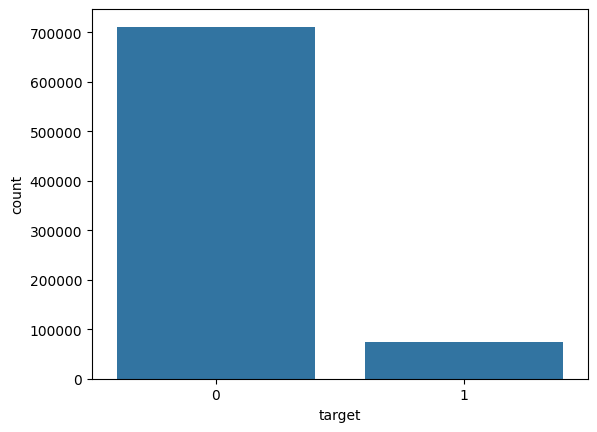

In [11]:
# Check and convert 'target' column
train_data['target'] = pd.to_numeric(train_data['target'], errors='coerce')
train_data = train_data.dropna(subset=['target'])

# Ensure 'target' is integer type
train_data['target'] = train_data['target'].astype(int)

# Plot the distribution
sns.countplot(x='target', data=train_data)
#plt.title('Target Variable Distribution')
#plt.show()

# Step 5: Data Preprocessing

- 5.1. Handle Missing Values
- Identify Columns with Missing Values

In [12]:
# Columns with missing values
missing_cols = train_data.columns[train_data.isnull().any()]
print("Columns with missing values:", missing_cols.tolist())

Columns with missing values: ['Column0', 'Column3', 'Column4', 'Column5', 'Column6', 'Column8', 'Column9', 'Column14', 'Column15']


- Impute Missing Values
- Numeric Columns

In [13]:
# Select numeric columns
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # Exclude the target variable if it's numeric

# Initialize imputer
numeric_imputer = SimpleImputer(strategy='median')

# Fit and transform
train_data[numeric_cols] = numeric_imputer.fit_transform(train_data[numeric_cols])

- Categorical Columns

In [14]:
# Select categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('ID')  # Exclude 'ID' column

# Fill missing values with 'Unknown'
train_data[categorical_cols] = train_data[categorical_cols].fillna('Unknown')

- 5.2. Encode Categorical Variables

In [15]:
# Initialize label encoders
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

- 5.3. Feature Scaling

In [16]:
# Initialize scaler
scaler = StandardScaler()

# Features (excluding 'ID' and 'target')
X_features = train_data.drop(['ID', 'target'], axis=1)

# Fit scaler on features
X_scaled = scaler.fit_transform(X_features)

# Step 6: Handling Imbalanced Data

- 6.1. Check Class Distribution

In [17]:
# Class distribution
train_data['target'].value_counts()

target
0    711100
1     74033
Name: count, dtype: int64

- 6.2. Apply SMOTE

In [18]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X_scaled, train_data['target'])

# Step 7: Splitting the Data

In [19]:
# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 8: Model Training and Evaluation

- 8.1. Initialize Models

In [20]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

- 8.2. Train and Evaluate Models

In [21]:
# Function to train and evaluate models
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        print(f"Results for {name}:")
        print("Accuracy:", accuracy_score(y_val, y_pred))
        print("Precision:", precision_score(y_val, y_pred))
        print("Recall:", recall_score(y_val, y_pred))
        print("F1 Score:", f1_score(y_val, y_pred))
        print("ROC AUC:", roc_auc_score(y_val, y_pred))
        print("-" * 30)

# Call the function
train_and_evaluate(models, X_train_split, y_train_split, X_val, y_val)

Training Logistic Regression...
Results for Logistic Regression:
Accuracy: 0.9807305582899732
Precision: 0.9633053012489073
Recall: 0.9995359302489102
F1 Score: 0.9810862386080907
ROC AUC: 0.9807305582899732
------------------------------
Training Random Forest...
Results for Random Forest:
Accuracy: 0.9862115033047392
Precision: 0.9739479095270733
Recall: 0.9991492054563352
F1 Score: 0.9863876162709982
ROC AUC: 0.9862115033047391
------------------------------
Training Gradient Boosting...
Results for Gradient Boosting:
Accuracy: 0.9830473913654901
Precision: 0.9680724943789603
Recall: 0.9990437350583603
F1 Score: 0.983314301532925
ROC AUC: 0.98304739136549
------------------------------
Training XGBoost...
Results for XGBoost:
Accuracy: 0.9853747714808044
Precision: 0.9740550488957257
Recall: 0.9973140205315708
F1 Score: 0.9855473255603886
ROC AUC: 0.9853747714808044
------------------------------


# Step 9: Hyperparameter Tuning

- 9.1. Define Parameter Grid for Random Forest

In [22]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

- 9.2. Perform Grid Search

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_split, y_train_split)

# Best estimator
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

- 9.3. Evaluate the Tuned Model

In [ ]:
# Predict with the best model
y_pred_best_rf = best_rf.predict(X_val)

# Evaluate
print("Best Random Forest Model Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred_best_rf))
print("Precision:", precision_score(y_val, y_pred_best_rf))
print("Recall:", recall_score(y_val, y_pred_best_rf))
print("F1 Score:", f1_score(y_val, y_pred_best_rf))
print("ROC AUC:", roc_auc_score(y_val, y_pred_best_rf))

# Step 10: Ensemble Modeling

- 10.1. Create a Voting Classifier

In [ ]:
# Initialize VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gbc', models['Gradient Boosting']),
        ('xgb', models['XGBoost'])
    ],
    voting='soft'
)

# Train the ensemble model
ensemble.fit(X_train_split, y_train_split)

- 10.2. Evaluate the Ensemble Model

In [ ]:
# Predict
y_pred_ensemble = ensemble.predict(X_val)

# Evaluate
print("Ensemble Model Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred_ensemble))
print("Precision:", precision_score(y_val, y_pred_ensemble))
print("Recall:", recall_score(y_val, y_pred_ensemble))
print("F1 Score:", f1_score(y_val, y_pred_ensemble))
print("ROC AUC:", roc_auc_score(y_val, y_pred_ensemble))

# Step 11: Model Interpretability

- 11.1. Initialize SHAP Explainer

In [ ]:
# Use TreeExplainer for ensemble models
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

- 11.2. Plot SHAP Summary

In [ ]:
# Plot summary
shap.summary_plot(shap_values[1], X_val)

# Step 12: Preparing Test Data and Making Predictions

- 12.1. Preprocess Test Data
- Handle Missing Values

In [ ]:
# Numeric columns
X_test[numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

# Categorical columns
X_test[categorical_cols] = X_test[categorical_cols].fillna('Unknown')

- Encode Categorical Variables

In [ ]:
# Encode using the same label encoders
for col in categorical_cols:
    le = label_encoders[col]
    X_test[col] = le.transform(X_test[col])

- Feature Scaling

In [ ]:
# Scale features
X_test_features = X_test.drop(['ID'], axis=1)
X_test_scaled = scaler.transform(X_test_features)

- 12.2. Make Predictions on Test Data

In [ ]:
# Use your final model (trained on the entire training data)
final_model = ensemble

# Retrain on full data
final_model.fit(X_resampled, y_resampled)

# Predict
y_pred_test = final_model.predict(X_test_scaled)

- 12.3. Prepare Submission File

In [ ]:
# Prepare submission DataFrame
submission = pd.DataFrame({
    'ID': X_test['ID'],
    'target': y_pred_test
})

# Save to CSV
submission.to_csv('Ypred_test.csv', index=False)

- 12.4. Evaluate on Test Targets (If Available)

In [ ]:
# If test targets are available
# Load test targets
y_test = pd.read_csv('Y_Test_Data_Target.csv')  # Uncomment if we have this file

# Evaluate
y_true = y_test['target']
y_pred = y_pred_test

Calculate metrics
print("Test Data Metrics:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_pred))

Step 13: Generating Reports and Visualizations

13.1. Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- 13.2. ROC Curve

In [ ]:
# ROC Curve
y_proba = ensemble.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label='Ensemble Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve on Validation Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

- 13.3. Feature Importances

In [ ]:
# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_
feature_names = X_features.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort and plot top features
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

- 14 Save the Model

In [ ]:
# Save the trained model
import joblib
joblib.dump(final_model, 'final_model.pkl')

In [ ]:
# Test basic plotting
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([1, 2, 3], [4, 5, 6])
plt.title('Test Plot')
plt.show()